Modeling

Import libraries

In [7]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from sklearn.linear_model import ElasticNet, LassoCV, BayesianRidge, RidgeCV, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
%autosave 30

Autosaving every 30 seconds


Reading our data

In [8]:
train = pd.read_csv("../data/train_new.csv")
X_test = pd.read_csv("../data/test_new.csv")
Id_test = pd.read_csv("../data/test.csv")["Id"]
print(train.shape)
print(X_test.shape)

(1457, 512)
(1459, 511)


Split data in features and labels

In [9]:
X_train = train.drop("SalePrice", axis=1)
y_train =train["SalePrice"]
print(X_train.shape)
print(y_train.shape)


(1457, 511)
(1457,)


Creating functions to calculate RMSE

In [10]:
n_folds=10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=21)

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsey(y_train, y_pred):
    rmsey = np.sqrt(mean_squared_error(y_train, y_pred))
    return(rmsey)


In [11]:
"""
param_grid = {"kernel":np.array(["linear", "rbf", "sigmoid", "precomputed"]),
                "gamma":np.array([0.0001, 0.002, 0.003]),
                "epsilon":np.array([0.002, 0.005, 0.008]),
                "C":np.array([5,10,15])}
model = SVR()
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=kf)
grid_result = grid.fit(X_train, y_train)

# muestra resultados de la busqueda grid
print("Mejor neg_mean_squared_error: %f con hyperparametro %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
"""

'\nparam_grid = {"kernel":np.array(["linear", "rbf", "sigmoid", "precomputed"]),\n                "gamma":np.array([0.0001, 0.002, 0.003]),\n                "epsilon":np.array([0.002, 0.005, 0.008]),\n                "C":np.array([5,10,15])}\nmodel = SVR()\ngrid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring=\'neg_mean_squared_error\', cv=kf)\ngrid_result = grid.fit(X_train, y_train)\n\n# muestra resultados de la busqueda grid\nprint("Mejor neg_mean_squared_error: %f con hyperparametro %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    \n'

Search the best basic model through a pipeline

In [12]:
pipeline = []
pipeline.append(("SVR", make_pipeline(RobustScaler(), SVR())))
pipeline.append(("Ridge", make_pipeline(RobustScaler(), RidgeCV(cv=kf))))
pipeline.append(("ElasticNet", make_pipeline(RobustScaler(), ElasticNet())))
pipeline.append(("Lasso", make_pipeline(RobustScaler(), LassoCV(cv=kf))))
pipeline.append(("Bayesian", make_pipeline(RobustScaler(), BayesianRidge())))
pipeline.append(("RandomForest", make_pipeline(RobustScaler(), RandomForestRegressor())))
pipeline.append(("GBR", make_pipeline(RobustScaler(), GradientBoostingRegressor())))
pipeline.append(("XGB", make_pipeline(RobustScaler(), xgb.XGBRegressor())))

result=[]
name=[]

for modelname, pipe in pipeline:
    print("{}: {:.4f} ({:.4f})".format(modelname, cv_rmse(pipe).mean(), cv_rmse(pipe).std()))
    result.append(cv_rmse(pipe))
    name.append(modelname)

SVR: 0.1446 (0.0258)
Ridge: 0.1105 (0.0125)
ElasticNet: 0.3994 (0.0174)
Lasso: 0.1096 (0.0123)
Bayesian: 0.1103 (0.0128)
RandomForest: 0.1322 (0.0123)
GBR: 0.1207 (0.0134)
XGB: 0.1272 (0.0135)


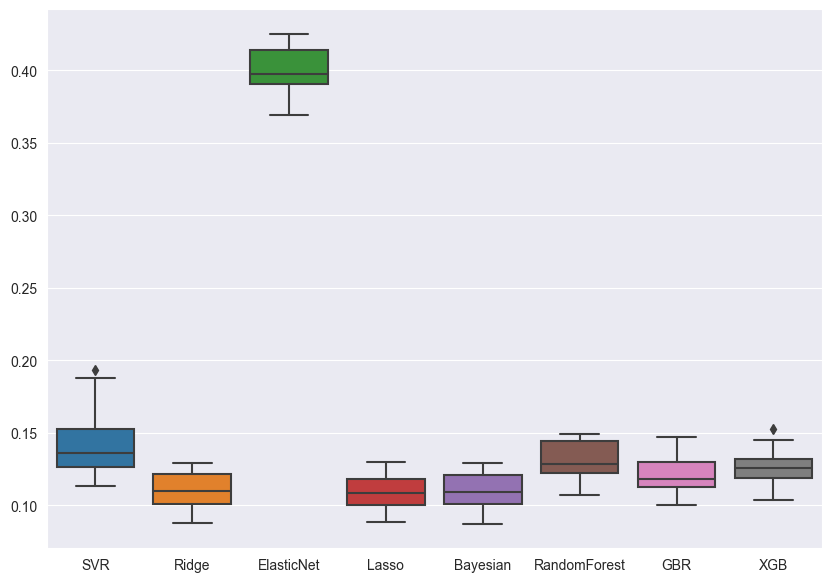

In [13]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(result)
ax.set_xticklabels(name)
plt.show()


Deeping in each model

In [14]:
ridge_alphas = [0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))
print("Ridge: {:.4f} ({:.4f})".format(cv_rmse(ridge).mean(), cv_rmse(ridge).std()))

Ridge: 0.1104 (0.0132)


In [15]:
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=[0.0003,0.0004,0.0005], cv=kf))
print("Lasso: {:.4f} ({:.4f})".format(cv_rmse(lasso).mean(), cv_rmse(lasso).std()))

Lasso: 0.1096 (0.0124)


In [16]:
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0002))
print("SVR: {:.4f} ({:.4f})".format(cv_rmse(svr).mean(), cv_rmse(svr).std()))

SVR: 0.1100 (0.0136)


In [17]:
elasticnet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.015, l1_ratio=0.008, random_state=21))
print("ElasticNet: {:.4f} ({:.4f})".format(cv_rmse(elasticnet).mean(), cv_rmse(elasticnet).std()))

ElasticNet: 0.1100 (0.0131)


In [18]:
gbr = make_pipeline(RobustScaler(), GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=42))
print("GradientBoosting: {:.4f} ({:.4f})".format(cv_rmse(gbr).mean(), cv_rmse(gbr).std()))

GradientBoosting: 0.1149 (0.0150)


In [19]:
xgb = make_pipeline(RobustScaler(), xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1))
print("XGB: {:.4f} ({:.4f})".format(cv_rmse(xgb).mean(), cv_rmse(xgb).std()))

[15:39:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[15:39:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[15:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[15:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[15:39:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[15:39:38] WARNING: 

Fit models

In [20]:
ridge_model = ridge.fit(X_train, y_train)
lasso_model = lasso.fit(X_train, y_train)
svr_model = svr.fit(X_train, y_train)
elasticnet_model = elasticnet.fit(X_train, y_train)
gbr_model = gbr.fit(X_train, y_train)
xgb_model = xgb.fit(X_train, y_train)

[15:40:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



Blend models and get predictions

In [21]:
ridge_pred = ridge_model.predict(X_train)
lasso_pred = lasso_model.predict(X_train)
svr_pred = svr_model.predict(X_train)
elasticnet_pred = elasticnet_model.predict(X_train)
xgb_pred = xgb_model.predict(X_train)
gbr_pred = gbr_model.predict(X_train)

In [22]:
score = []
ridge_score = rmsey(y_train, ridge_pred)
lasso_score = rmsey(y_train, lasso_pred)
svr_score = rmsey(y_train, svr_pred)
elasticnet_score = rmsey(y_train, elasticnet_pred)
xgb_score = rmsey(y_train, xgb_pred)
gbr_score = rmsey(y_train, gbr_pred)

In [23]:
print(ridge_score, lasso_score, svr_score, elasticnet_score, xgb_score, gbr_score)

0.0938271142008959 0.09708690703764553 0.0953857444190059 0.09740710443366789 0.0782961102894048 0.05471900899391118


In [24]:
def blended():
    return ((0.2 * ridge_pred) + \
            (0.2 * xgb_pred) + \
            (0.6 * gbr_pred))

In [25]:
blended_score = rmsey(y_train, blended())
print(blended_score)

0.061876597735724403


Ensemble

In [26]:
ridge_pred_test = ridge_model.predict(X_test)
xgb_pred_test = xgb_model.predict(X_test)
gbr_pred_test = gbr_model.predict(X_test)

In [27]:
ensemble = 0.2 * ridge_pred_test + 0.2 * xgb_pred_test + 0.6 * gbr_pred_test
ensemble.shape

(1459,)

Sunmission

In [28]:
"""sub = pd.DataFrame()
sub['Id'] = Id_test
sub['SalePrice'] = np.exp(ensemble)
print(sub.head())
sub.to_csv('../data/submission.csv',index=False)"""

"sub = pd.DataFrame()\nsub['Id'] = Id_test\nsub['SalePrice'] = np.exp(ensemble)\nprint(sub.head())\nsub.to_csv('../data/submission.csv',index=False)"